In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost 
import lightgbm 

In [138]:
! pip install transformers

In [139]:
dataset=pd.read_csv("/kaggle/input/india-headlines-news-dataset/india-news-headlines.csv")
dataset.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [140]:
len(dataset)

3876557

In [141]:
dataset.columns

Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

# **Process the dataset:**

In [142]:
dataset = dataset[['publish_date', 'headline_text']]

In [143]:
missing_values = dataset.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 publish_date     0
headline_text    0
dtype: int64


In [144]:
dataset.dropna(inplace=True)
dataset.head(10)

,publish_date,headline_text
0,20010102,Status quo will not be disturbed at Ayodhya; s...
1,20010102,Fissures in Hurriyat over Pak visit
2,20010102,America's unwanted heading for India?
3,20010102,For bigwigs; it is destination Goa
4,20010102,Extra buses to clear tourist traffic
5,20010102,Dilute the power of transfers; says Riberio
6,20010102,Focus shifts to teaching of Hindi
7,20010102,IT will become compulsory in schools
8,20010102,Move to stop freedom fighters' pension flayed
9,20010102,Gilani claims he applied for passport 2 years ago


In [145]:
dataset['publish_date'] = pd.to_datetime(dataset['publish_date'], format='%Y%m%d')



In [146]:
dataset.head()

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic


# **Feature Engineering Process:**

In [147]:
dataset.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
dataset["headline_text"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1                  Fissures in Hurriyat over Pak visit
2                America's unwanted heading for India 
3                   For bigwigs  it is destination Goa
4                 Extra buses to clear tourist traffic
Name: headline_text, dtype: object

In [148]:
dataset.head(10)

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India
3,2001-01-02,For bigwigs it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic
5,2001-01-02,Dilute the power of transfers says Riberio
6,2001-01-02,Focus shifts to teaching of Hindi
7,2001-01-02,IT will become compulsory in schools
8,2001-01-02,Move to stop freedom fighters' pension flayed
9,2001-01-02,Gilani claims he applied for passport years ago


In [149]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch


In [151]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [152]:
def get_sentiment(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze()
    predicted_class = torch.argmax(probabilities).item()
    return predicted_class

In [153]:
headlines = dataset['headline_text'].tolist()
headlines[:100]

['Status quo will not be disturbed at Ayodhya  says Vajpayee',
 'Fissures in Hurriyat over Pak visit',
 "America's unwanted heading for India ",
 'For bigwigs  it is destination Goa',
 'Extra buses to clear tourist traffic',
 'Dilute the power of transfers  says Riberio',
 'Focus shifts to teaching of Hindi',
 'IT will become compulsory in schools',
 "Move to stop freedom fighters' pension flayed",
 'Gilani claims he applied for passport   years ago',
 "Parivar dismisses PM's warning",
 'India  Pak exchange lists of N plants',
 "Will Qureshi's return really help the govt ",
 "PM's tacit message  Put Ram tample on hold",
 "Text of the Prime Minister's article",
 'NCW to focus on violence against women',
 "BBC's reality TV will focus on AIIMS",
 'Jaitley firm on legal reforms',
 'Hoshangabad farmers have enough water',
 'BJP jumps into rail track conversion issue',
 "America's unwanted heading for India ",
 'State may take AP to court over Krishna',
 'This official has sued the briber',


In [154]:
sentiment_counts = {'negative': 0, 'neutral': 0, 'positive': 0}
for headline in tqdm(headlines[:5000]):  # Start from the 5000th index
    sentiment = get_sentiment(headline)
    if sentiment == 0:
        sentiment_counts['negative'] += 1
    elif sentiment == 1:
        sentiment_counts['neutral'] += 1
    elif sentiment == 2:
        sentiment_counts['positive'] += 1


100%|██████████| 5000/5000 [00:33<00:00, 148.28it/s]


### **Starting 2000 th data points:**

In [155]:
sentiments = []
for headline in tqdm(headlines[:2000]):
    sentiment = get_sentiment(headline)
    sentiments.append(sentiment)

# Create a new DataFrame for the new dataset
new_dataset = pd.DataFrame()
new_dataset['headline_text'] = headlines[:2000]
new_dataset['sentiment'] = sentiments

# Map sentiment labels to 'negative', 'neutral', 'positive'
sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
new_dataset['sentiment'] = new_dataset['sentiment'].map(sentiment_labels)


100%|██████████| 2000/2000 [00:12<00:00, 154.06it/s]


In [158]:
new_dataset.head()

,headline_text,sentiment
0,Status quo will not be disturbed at Ayodhya s...,negative
1,Fissures in Hurriyat over Pak visit,negative
2,America's unwanted heading for India,neutral
3,For bigwigs it is destination Goa,neutral
4,Extra buses to clear tourist traffic,neutral


In [159]:
len(new_dataset)

2000

In [163]:
publish_dates = dataset['publish_date'].tolist()


In [166]:
len(publish_dates)

3876557

In [168]:

new_dataset['publish_date'] = publish_dates[:2000]

In [169]:
new_dataset.head()

,headline_text,sentiment,publish_date
0,Status quo will not be disturbed at Ayodhya s...,negative,2001-01-02
1,Fissures in Hurriyat over Pak visit,negative,2001-01-02
2,America's unwanted heading for India,neutral,2001-01-02
3,For bigwigs it is destination Goa,neutral,2001-01-02
4,Extra buses to clear tourist traffic,neutral,2001-01-02


In [170]:
sentiment_counts = new_dataset['sentiment'].value_counts()
sentiment_counts

sentiment
neutral     1366
negative     634
Name: count, dtype: int64

In [171]:
new_dataset.head(10)

,headline_text,sentiment,publish_date
0,Status quo will not be disturbed at Ayodhya s...,negative,2001-01-02
1,Fissures in Hurriyat over Pak visit,negative,2001-01-02
2,America's unwanted heading for India,neutral,2001-01-02
3,For bigwigs it is destination Goa,neutral,2001-01-02
4,Extra buses to clear tourist traffic,neutral,2001-01-02
5,Dilute the power of transfers says Riberio,negative,2001-01-02
6,Focus shifts to teaching of Hindi,negative,2001-01-02
7,IT will become compulsory in schools,negative,2001-01-02
8,Move to stop freedom fighters' pension flayed,neutral,2001-01-02
9,Gilani claims he applied for passport years ago,neutral,2001-01-02


In [172]:
len(new_dataset)

2000

In [173]:
! pip install yfinance

In [174]:
import yfinance as yf
stock_data = yf.download('QMCI', start=new_dataset['publish_date'].min(), end=new_dataset['publish_date'].max())


[*********************100%%**********************]  1 of 1 completed


In [176]:
# Reset index to make 'Date' a column
stock_data.reset_index(inplace=True)

# Merge datasets on publish_date
merged_data = pd.merge(new_dataset, stock_data, left_on='publish_date', right_on='Date', how='inner')


In [177]:
merged_data.head()

,headline_text,sentiment,publish_date,index,Date,Open,High,Low,Close,Adj Close,Volume
0,Status quo will not be disturbed at Ayodhya s...,negative,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900
1,Fissures in Hurriyat over Pak visit,negative,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900
2,America's unwanted heading for India,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900
3,For bigwigs it is destination Goa,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900
4,Extra buses to clear tourist traffic,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900


In [178]:
# Classify sentiment labels
def classify_sentiment_label(sentiment):
    if sentiment == 'positive':
        return 2
    elif sentiment == 'negative':
        return 0
    else:
        return 1

# Add label column to the merged dataset
merged_data['label'] = merged_data['sentiment'].apply(classify_sentiment_label)


In [179]:
merged_data.head()

,headline_text,sentiment,publish_date,index,Date,Open,High,Low,Close,Adj Close,Volume,label
0,Status quo will not be disturbed at Ayodhya s...,negative,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,0
1,Fissures in Hurriyat over Pak visit,negative,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,0
2,America's unwanted heading for India,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,1
3,For bigwigs it is destination Goa,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,1
4,Extra buses to clear tourist traffic,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,1


In [180]:
# Calculate stock returns
merged_data['Stock_Return'] = merged_data['Close'].pct_change()

# Classify stock condition based on sentiment
def classify_stock_condition(label):
    if label == 2:
        return 'Positive'
    elif label == 0:
        return 'Negative'
    else:
        return 'Neutral'

In [181]:
merged_data['Stock_Condition'] = merged_data['label'].apply(classify_stock_condition)

# Analyze stock condition
stock_condition_counts = merged_data['Stock_Condition'].value_counts()



In [182]:
merged_data.head()

,headline_text,sentiment,publish_date,index,Date,Open,High,Low,Close,Adj Close,Volume,label,Stock_Return,Stock_Condition
0,Status quo will not be disturbed at Ayodhya s...,negative,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,0,NaN,Negative
1,Fissures in Hurriyat over Pak visit,negative,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,0,0.0,Negative
2,America's unwanted heading for India,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,1,0.0,Neutral
3,For bigwigs it is destination Goa,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,1,0.0,Neutral
4,Extra buses to clear tourist traffic,neutral,2001-01-02,0,2001-01-02,0.109375,0.109375,0.109375,0.109375,0.109375,9900,1,0.0,Neutral


In [183]:
stock_condition_counts.head()

Stock_Condition
Neutral     1028
Negative     511
Name: count, dtype: int64

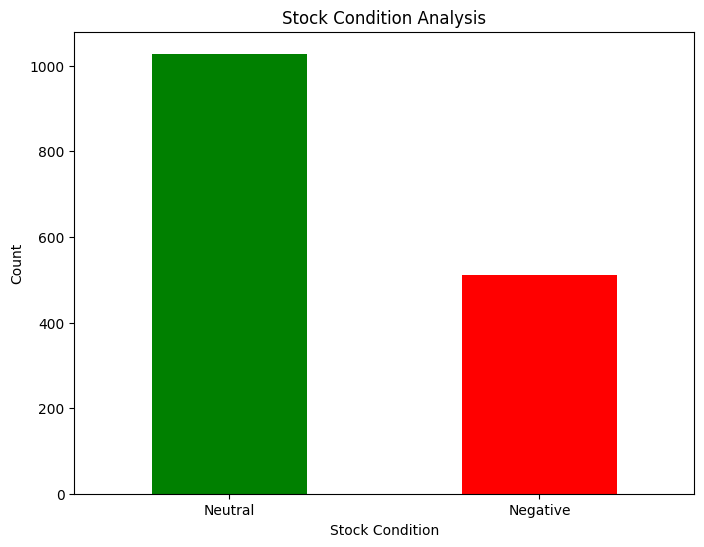

In [184]:
plt.figure(figsize=(8, 6))
merged_data['Stock_Condition'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Stock Condition Analysis')
plt.xlabel('Stock Condition')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

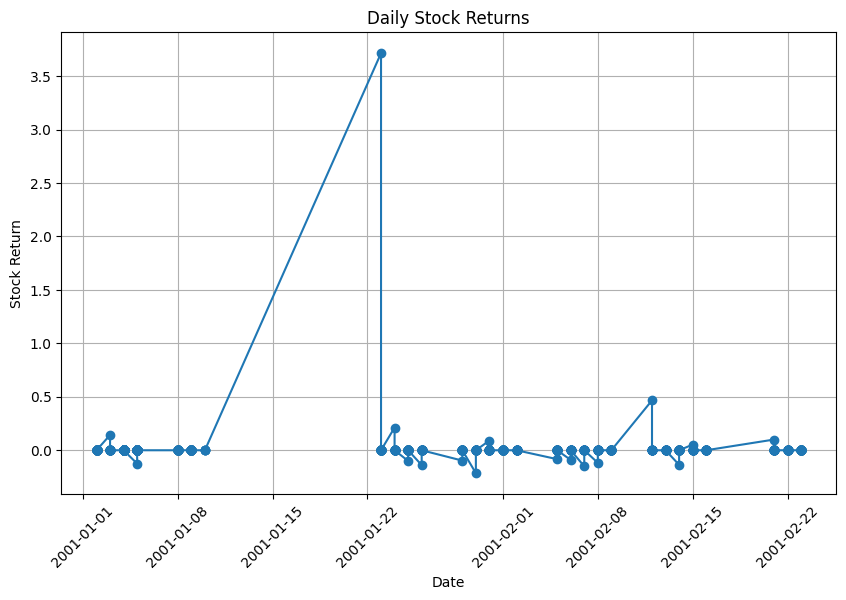

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Date'], merged_data['Stock_Return'], marker='o', linestyle='-')
plt.title('Daily Stock Returns')
plt.xlabel('Date')
plt.ylabel('Stock Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


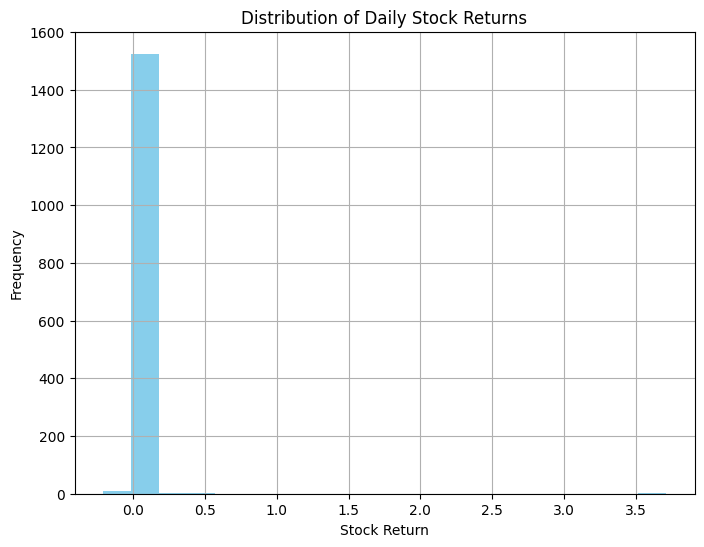

In [186]:
plt.figure(figsize=(8, 6))
plt.hist(merged_data['Stock_Return'].dropna(), bins=20, color='skyblue')
plt.title('Distribution of Daily Stock Returns')
plt.xlabel('Stock Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()